In [1]:
#decide which size of T5 to use
t5_model = 't5-small'
#choose whether to save the model that will be trained
save_model = True
VERSION="drop-60epochs-v0"
#choose whether to load the weights of a previously trained model
load_model = False
load_version = 'drop-v0'
#choose whether to train the model
train_model = True
#choose whether to use a learning rate scheduler with warm-up & decay
use_learning_schedule = True

#choose whether to predict on train and/or dev sets
predict_train = False
predict_dev = True
#choose whether to save prediction results to pickle folder
save_results = True

#choose whether to run a toy size dataset
run_toy = False
toy_size = 1000
#choose number of epochs
epochs = 60
#choose batch size
batch_size = 8
#choose dataset to use
dataset='drop' #acceptable values: drop, squad, hotpot_qa, augmented

#additional parameters
encoder_max_len = 512 #250
decoder_max_len = 54
buffer_size = 1000

# Using T5 on DROP

#### Package installs

#### check gpu

In [2]:
!nvidia-smi

Wed Jul 21 21:44:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.80       Driver Version: 460.80       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:01:00.0  On |                  N/A |
|  0%   55C    P8    49W / 420W |    570MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### Download drop_eval module and set directories

https://github.com/allenai/allennlp-reading-comprehension/blob/master/allennlp_rc/eval/drop_eval.py

In [3]:
!wget https://raw.githubusercontent.com/allenai/allennlp-reading-comprehension/master/allennlp_rc/eval/drop_eval.py -O drop_eval.py
import os
def create_dir(d,verbose=False):
    if not os.path.exists(d):
        !mkdir -p $d    
        if verbose: print(f'created folder for {d}')
    else:
        if verbose: print(f'using existing folder for {d}\nCAUTION -- this run may overwrite existing data!')
    
#set directories
root_dir = './data'
data_dir = f"./data/{VERSION}/{t5_model}"
augmented_dir = f"{root_dir}/augmented-data"
results_dir = f"{data_dir}/results/"
log_dir = f"{data_dir}/experiments/logs"
save_dir = f"{data_dir}/experiments/models"
load_dir = f"{root_dir}/{load_version}/{t5_model}/experiments/models"

create_dir(root_dir)
create_dir(data_dir)
create_dir(augmented_dir)
create_dir(results_dir)
create_dir(log_dir)
create_dir(save_dir)

if load_model:
    assert os.path.exists(load_dir), 'Error - trying to load a model that doesnt exist'

--2021-07-21 21:44:37--  https://raw.githubusercontent.com/allenai/allennlp-reading-comprehension/master/allennlp_rc/eval/drop_eval.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11222 (11K) [text/plain]
Saving to: ‘drop_eval.py’

drop_eval.py        100%[===================>]  10.96K  --.-KB/s    in 0.004s  

2021-07-21 21:44:37 (2.71 MB/s) - ‘drop_eval.py’ saved [11222/11222]



#### load packages

In [4]:
# import warnings
# warnings.filterwarnings('ignore')
# warnings.simplefilter('ignore')


# import logging
# logging.getLogger("tensorflow").setLevel(logging.ERROR)
# logging.getLogger("tensorflow").addHandler(logging.NullHandler(logging.ERROR))
from transformers import T5Tokenizer, TFT5ForConditionalGeneration
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow.keras as keras
import drop_eval
import pandas as pd
import numpy as np
import json
from datasets import Dataset, load_dataset
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime
import re

from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.notebook import tqdm,trange

%load_ext tensorboard

assert len(tf.config.list_physical_devices("GPU")) > 0, "No GPU found by Tensorflow"

if(run_toy): print(f'Running on {toy_size:,} records for development run')
    
!nvcc -V

2021-07-21 21:44:38.346529: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Wed_Jun__2_19:15:15_PDT_2021
Cuda compilation tools, release 11.4, V11.4.48
Build cuda_11.4.r11.4/compiler.30033411_0


2021-07-21 21:44:39.568672: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-21 21:44:39.580904: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-21 21:44:39.581665: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.8GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2021-07-21 21:44:39.581683: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-21 21:44:39.583875: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-07-21 21:44:39.583904: I tensorflow/stream_executor/platform/de

#### Define model class

In [5]:

class T5forDrop(TFT5ForConditionalGeneration):
    def __init__(self, *args, log_dir=None, cache_dir= None, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_tracker= tf.keras.metrics.Mean(name='loss')
        self.F1_tracker= tf.keras.metrics.Mean(name='F1')
        self.EM_tracker= tf.keras.metrics.Mean(name='EM')        

    
    @tf.function
    def train_step(self, data):
        x = data
        y_true = x["labels"]
        with tf.GradientTape() as tape:
            outputs = self(x, training=True)
            logits = outputs['logits']
            y_pred = tf.math.argmax(tf.nn.softmax(logits,axis=2), axis = 2, output_type=tf.int32)
            loss = tf.reduce_mean(outputs['loss'])            
            grads = tape.gradient(loss, self.trainable_variables)

        # Calculate F1 and EM Metrics
        # Create a word mask to not count the padding/sentence tokens
        recall_word_mask = tf.math.logical_and(
                    tf.math.not_equal(y_true,0)
                    ,tf.math.not_equal(y_true,1))

        precision_word_mask = tf.math.logical_and(
                    tf.math.not_equal(y_pred,0)
                    ,tf.math.not_equal(y_pred,1))

        # match the tokens
        match_token = tf.math.equal(y_true,y_pred)
        recall_match = tf.math.logical_and(match_token,recall_word_mask) 
        precision_match = tf.math.logical_and(match_token,precision_word_mask) 

        # calculate score
        precision_array = tf.math.reduce_sum(tf.cast(precision_match, tf.int32) ,axis=1)/tf.math.reduce_sum(tf.cast(precision_word_mask, tf.int32) ,axis=1)
        recall_array = tf.math.reduce_sum(tf.cast(recall_match, tf.int32) ,axis=1)/tf.math.reduce_sum(tf.cast(recall_word_mask, tf.int32) ,axis=1)

        P = tf.math.reduce_mean(precision_array)
        R = tf.math.reduce_mean(recall_array)

        EM = tf.math.reduce_mean(
            tf.cast(tf.math.logical_and(
                    tf.math.equal(precision_array,1)
                    ,tf.math.equal(recall_array,1)), tf.int32))
        F1 = 2*(P*R)/(P+R)
        
        '''
        Note, since FP and FN are the same, 
        the F1 score is the same as Precision, Recall, 
        which is the average "match" score
        '''

        y_true = tf.reshape(y_true, [-1, 1])

        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        lr = self.optimizer._decayed_lr(tf.float32)

        self.loss_tracker.update_state(loss)
        self.F1_tracker.update_state(F1)   
        self.EM_tracker.update_state(EM)           
        self.compiled_metrics.update_state(y_true, logits)
        metrics = {m.name: m.result() for m in self.metrics}
        metrics.update({'lr': lr})
        
        return metrics

    def test_step(self, data):
        x = data
        y_true = x["labels"]
        outputs = self(x, training=True)
        logits = outputs['logits']
        y_pred = tf.math.argmax(tf.nn.softmax(logits,axis=2), axis = 2, output_type=tf.int32)
        loss = tf.reduce_mean(outputs['loss'])      
        
        # Calculate F1 and EM Metrics
        # Create a word mask to not count the padding/sentence tokens
        recall_word_mask = tf.math.logical_and(
                    tf.math.not_equal(y_true,0)
                    ,tf.math.not_equal(y_true,1))

        precision_word_mask = tf.math.logical_and(
                    tf.math.not_equal(y_pred,0)
                    ,tf.math.not_equal(y_pred,1))

        # match the tokens
        match_token = tf.math.equal(y_true,y_pred)
        recall_match = tf.math.logical_and(match_token,recall_word_mask) 
        precision_match = tf.math.logical_and(match_token,precision_word_mask) 

        # calculate score
        precision_array = tf.math.reduce_sum(tf.cast(precision_match, tf.int32) ,axis=1)/tf.math.reduce_sum(tf.cast(precision_word_mask, tf.int32) ,axis=1)
        recall_array = tf.math.reduce_sum(tf.cast(recall_match, tf.int32) ,axis=1)/tf.math.reduce_sum(tf.cast(recall_word_mask, tf.int32) ,axis=1)

        P = tf.math.reduce_mean(precision_array)
        R = tf.math.reduce_mean(recall_array)

        EM = tf.math.reduce_mean(
            tf.cast(tf.math.logical_and(
                    tf.math.equal(precision_array,1)
                    ,tf.math.equal(recall_array,1)), tf.int32))
        F1 = 2*(P*R)/(P+R)

        y_true = tf.reshape(y_true, [-1, 1])

        self.loss_tracker.update_state(loss)
        self.F1_tracker.update_state(F1)   
        self.EM_tracker.update_state(EM)           
        self.compiled_metrics.update_state(y_true, logits)
        metrics = {m.name: m.result() for m in self.metrics}        
        return metrics

#### Import model and tokenizer

In [6]:
tokenizer = T5Tokenizer.from_pretrained(t5_model)
#replace numbers with special tokens
numbers = {'additional_special_tokens':['1','2','3','4','5','6','7','8','9','0','<ss>','<sv>']}
num_tokens_added = tokenizer.add_special_tokens(numbers)


model = T5forDrop.from_pretrained(t5_model)

2021-07-21 21:44:41.668406: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-07-21 21:44:41.669987: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-21 21:44:41.672450: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.8GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2021-07-21 21:44:41.672614: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1),

#### Import data

In [7]:
def make_toy(dataset,toy_size=1000):
    df = dataset.to_pandas()
    df = df.head(toy_size)
    return Dataset.from_pandas(df)

In [8]:
if dataset == "hotpot_qa":
    train_dataset_full = load_dataset(dataset,'distractor', split='train')
    valid_dataset_full = load_dataset(dataset,'distractor', split='validation')
elif dataset == 'augmented':
    full_df = pd.read_pickle(augmented_dir+'/augmented_data.pkl')
    train_dataset_full, valid_dataset_full = train_test_split(full_df,test_size=0.2)
    train_dataset_full = Dataset.from_pandas(train_dataset_full)
    valid_dataset_full = Dataset.from_pandas(valid_dataset_full)
    
else:
    train_dataset_full = load_dataset(dataset, split='train')
    valid_dataset_full = load_dataset(dataset, split='validation')

print('Dataset features: ',train_dataset_full.features)

#reduce data to toy size if run_toy flag is set
if(run_toy):
    train_dataset = make_toy(train_dataset_full)
    valid_dataset = make_toy(valid_dataset_full)

else:
    train_dataset = train_dataset_full
    valid_dataset = valid_dataset_full
    
#check out one record
data = next(iter(valid_dataset))
print("\n\nExample data from the dataset: \n", data)

Using custom data configuration default
Reusing dataset drop (/home/omar/.cache/huggingface/datasets/drop/default/0.1.0/393cc04823935c1302a6a7e380cdbe9f452d37858ea276409787c983748eae25)
Using custom data configuration default
Reusing dataset drop (/home/omar/.cache/huggingface/datasets/drop/default/0.1.0/393cc04823935c1302a6a7e380cdbe9f452d37858ea276409787c983748eae25)


Dataset features:  {'section_id': Value(dtype='string', id=None), 'query_id': Value(dtype='string', id=None), 'passage': Value(dtype='string', id=None), 'question': Value(dtype='string', id=None), 'answers_spans': Sequence(feature={'spans': Value(dtype='string', id=None), 'types': Value(dtype='string', id=None)}, length=-1, id=None)}


Example data from the dataset: 
 {'section_id': 'nfl_1184', 'query_id': 'f37e81fa-ef7b-4583-b671-762fc433faa9', 'passage': " Hoping to rebound from their loss to the Patriots, the Raiders stayed at home for a Week 16 duel with the Houston Texans.  Oakland would get the early lead in the first quarter as quarterback JaMarcus Russell completed a 20-yard touchdown pass to rookie wide receiver Chaz Schilens.  The Texans would respond with fullback Vonta Leach getting a 1-yard touchdown run, yet the Raiders would answer with kicker Sebastian Janikowski getting a 33-yard and a 30-yard field goal.  Houston would tie the game in the second quarter with kicker Kr

#### set parameters

In [9]:
steps = int(np.ceil(len(train_dataset)/batch_size))
valid_steps = int(np.ceil(len(valid_dataset)/batch_size))
print('Training datset size: {:,} records'.format(len(train_dataset)))
print('Validation datset size: {:,} records'.format(len(valid_dataset)))
print('Batch size: {}'.format(batch_size))
print("Total Steps: {:,}".format(steps))
print("Total Validation Steps: {:,}".format(valid_steps))

Training datset size: 77,400 records
Validation datset size: 9,535 records
Batch size: 8
Total Steps: 9,675
Total Validation Steps: 1,192


#### Preprocess data

In [10]:
def encode(example,
           encoder_max_len=encoder_max_len, decoder_max_len=decoder_max_len):
  
    if dataset == 'drop':
        context = example['passage']
        question = example['question']

        answer = example['answers_spans']['spans']
        answer_type = example['answers_spans']['types']
    elif dataset == 'squad':
        context = example['context']
        question = example['question']
        
        answer = example['answers']['text']
        answer_type = 'text'
    elif dataset == 'hotpot_qa':
        context = ''
        for sentence in example["context"]["sentences"]:
            context += " ".join(sentence) + " "
        question = example['question']
        
        answer = [example['answer']]
        answer_type = 'text'    
    elif dataset == 'augmented':
        context = example['context']
        question = example['question']
        answer = [example['answer']]
        answer_type = example['qtype']
    
    question_plus = f"answer_me: {str(question)}"
    question_plus += f" context: {str(context)}"
    
    answer_plus = ', '.join([i for i in list(answer)])
    answer_plus = f"{answer_plus}"
    
    encoder_inputs = tokenizer(question_plus, truncation=True, 
                               return_tensors='tf', max_length=encoder_max_len,
                              pad_to_max_length=True)
    
    decoder_inputs = tokenizer(answer_plus, truncation=True, 
                               return_tensors='tf', max_length=decoder_max_len,
                              pad_to_max_length=True)
    
    input_ids = encoder_inputs['input_ids'][0]
    input_attention = encoder_inputs['attention_mask'][0]
    target_ids = decoder_inputs['input_ids'][0]
    target_attention = decoder_inputs['attention_mask'][0]
    
    outputs = {'input_ids':input_ids, 'attention_mask': input_attention, 
               'labels':target_ids, 'decoder_attention_mask':target_attention,
                }
    return outputs
    
def to_tf_dataset(dataset):
    '''convert from arrow to TF dataset'''
    
    columns = ['input_ids', 'attention_mask', 'labels', 'decoder_attention_mask']
    dataset.set_format(type='tensorflow', columns=columns)
    return_types = {'input_ids':tf.int32, 'attention_mask':tf.int32, 
                'labels':tf.int32, 'decoder_attention_mask':tf.int32,}
    return_shapes = {'input_ids': tf.TensorShape([None]), 'attention_mask': tf.TensorShape([None]), 
                  'labels': tf.TensorShape([None]), 'decoder_attention_mask':tf.TensorShape([None]),}
    ds = tf.data.Dataset.from_generator(lambda : dataset, return_types, return_shapes)
    return ds

def create_dataset(dataset, cache_path=None, batch_size=batch_size, 
                   buffer_size= 1000, shuffling=True):
    '''returns a padded_batch tf dataset'''
    if cache_path is not None:
        dataset = dataset.cache(cache_path)        
    if shuffling:
        dataset = dataset.shuffle(buffer_size)
    dataset = dataset.padded_batch(batch_size)
#     dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset



In [11]:
#Preprocess data
train_ds = train_dataset.map(encode)
valid_ds = valid_dataset.map(encode)

tf_train_ds = to_tf_dataset(train_ds)
tf_train_ds = tf_train_ds.repeat(epochs)

tf_valid_ds = to_tf_dataset(valid_ds)

tf_train_ds= create_dataset(tf_train_ds, batch_size=batch_size, 
                         shuffling=True, cache_path = None)
tf_valid_ds = create_dataset(tf_valid_ds, batch_size=batch_size, 
                         shuffling=False, cache_path = None)

print('dataset schema:')
tf_train_ds.element_spec

/home/omar/miniconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2104: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(



dataset schema:


{'input_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name=None),
 'attention_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name=None),
 'labels': TensorSpec(shape=(None, None), dtype=tf.int32, name=None),
 'decoder_attention_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name=None)}

#### Callbacks and checkpoints

In [12]:
# Learning Rate Schedule to input into CustomLearningRateScheduler()
def lr_schedule(training_steps, lr):
    """Helper function to retrieve the scheduled learning rate based on epoch."""
    if training_steps < __TOTAL_WARM_UP_STEPS:
        # print("\nWARM UP: Using Increasing Linear Function at Training Step:{}".format(training_steps))
        lr = ((MAX_LR - START_LR)/__TOTAL_WARM_UP_STEPS) * training_steps + START_LR # y = (m)x + b
    else:
        __CURRENT_DECAY_STEP = training_steps - __TOTAL_WARM_UP_STEPS
        if DECAY == "ExponentialDecay":
            # print("\nDECAY: Using ExponentialDecay at Training Step:{}".format(training_steps))
            __DECAY_FN = keras.optimizers.schedules.ExponentialDecay(
                  initial_learning_rate=MAX_LR,
                  decay_steps=__TOTAL_DECAY_STEPS,
                  decay_rate=END_LR/MAX_LR)
        elif DECAY == "PiecewiseConstantDecay":
            # print("\nDECAY: Using PiecewiseConstantDecay at Training Step:{}".format(training_steps))
            __CURRENT_DECAY_STEP = tf.Variable(__CURRENT_DECAY_STEP, trainable=False)
            __DECAY_FN = keras.optimizers.schedules.PiecewiseConstantDecay(
                  __BOUNDARIES, __VALUES)
        elif DECAY == "PolynomialDecay":
            # print("\nDECAY: Using PolynomialDecay at Training Step:{}".format(training_steps))
            __DECAY_FN = tf.keras.optimizers.schedules.PolynomialDecay(
                  MAX_LR,
                  __TOTAL_DECAY_STEPS,
                  END_LR,
                  power=POWER)
        elif DECAY == "InverseTimeDecay":
            # print("DECAY: Using InverseTimeDecay at Training Step:{}".format(training_steps))
            __DECAY_FN = keras.optimizers.schedules.InverseTimeDecay(
                  MAX_LR, __TIME_DECAY, 1)
        else:
            print("Please Select a Decay Function")
            exit
        lr = __DECAY_FN(__CURRENT_DECAY_STEP)
    return lr

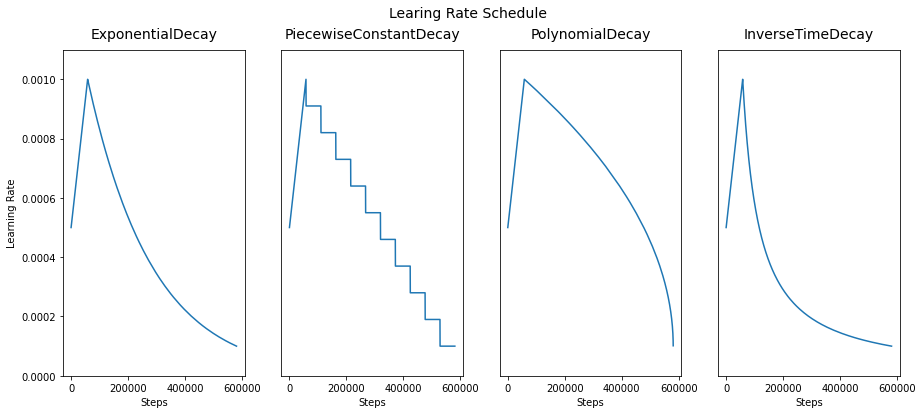

In [13]:
# Learning Rate Schedule Parameters
WARM_UP_FRACTION = 1/10 #The fraction of the training steps that will be ramping up linearly to the max LR
START_LR = 0.0005 # must be float
MAX_LR = 0.001 # must be float
END_LR = 0.0001 # must be float

EPOCHS = epochs
STEPS_PER_EPOCH = steps
__TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH
__TOTAL_WARM_UP_STEPS = __TOTAL_STEPS * WARM_UP_FRACTION
__TOTAL_DECAY_STEPS = __TOTAL_STEPS - __TOTAL_WARM_UP_STEPS

#--------------------------------------------------------------------------------------------

# Decay Parameters
# ExponentialDecay - None

# PiecewiseConstantDecay
NUM_BOUNDARIES = 10
__BOUNDARY_STEP = __TOTAL_DECAY_STEPS/NUM_BOUNDARIES
__BOUNDARIES = list(np.arange(0,__TOTAL_DECAY_STEPS+__BOUNDARY_STEP,__BOUNDARY_STEP))
__PIECEWISE_STEP = (MAX_LR - END_LR)/(NUM_BOUNDARIES)
__VALUES = list(np.arange(MAX_LR,END_LR-__PIECEWISE_STEP,-__PIECEWISE_STEP))

# PolynomialDecay
POWER = .5 # Must be > 1 to reach END_LR

#InverseTimeDecay
__TIME_DECAY = __TOTAL_DECAY_STEPS/(MAX_LR/END_LR-1)

#--------------------------------------------------------------------------------------------
# Initialize Graphing
decay_array = ["ExponentialDecay", "PiecewiseConstantDecay", "PolynomialDecay", "InverseTimeDecay"]
x = range(__TOTAL_STEPS)

fig, ax = plt.subplots(figsize=(15, 6),ncols=len(decay_array))
fig.suptitle(f'Learing Rate Schedule', fontsize=14)
ymax = max(START_LR,MAX_LR,END_LR)
ymax *= 1.1


ax[0].set_ylabel('Learning Rate')
for i,decay_type in enumerate(decay_array):
    DECAY = decay_type
    lr_values = []
    for step in x:
        lr_values.append(lr_schedule(step,0))
    ax[i].plot(x,lr_values)
    ax[i].set_title(decay_type, fontsize=14, pad=11)
    ax[i].set_xlabel('Steps')
    ax[i].set_ylim([0,ymax])
    if i > 0:
        ax[i].tick_params(which='both', left=False, labelleft=False)
plt.show()
#--------------------------------------------------------------------------------------------

# ACTION: Select Decay Type
DECAY = "PiecewiseConstantDecay" #["ExponentialDecay", "PiecewiseConstantDecay", "PolynomialDecay", "InverseTimeDecay"]

In [14]:
class CustomLearningRateScheduler(keras.callbacks.Callback):
    """Learning rate scheduler which sets the learning rate according to schedule.

  Arguments:
      schedule: a function that takes an epoch index
          (integer, indexed from 0) and current learning rate
          as inputs and returns a new learning rate as output (float).
  """

    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule
        self.current_epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        self.current_epoch += 1

    def on_batch_begin(self, batch_step, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # Get the current learning rate from model's optimizer.
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        # Call schedule function to get the scheduled learning rate.
        total_steps = batch_step + self.current_epoch * steps
        scheduled_lr = self.schedule(total_steps, lr)
        # Set the value back to the optimizer before this epoch starts
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        # print("\nEpoch %05d: Learning rate is %6.4f." % (total_steps, scheduled_lr))

In [15]:
start_profile_batch = steps+10
stop_profile_batch = start_profile_batch + 100
profile_range = f"{start_profile_batch},{stop_profile_batch}"

log_path = log_dir + "/" + datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_path, histogram_freq=1,
                                                     update_freq=20,profile_batch=profile_range)

checkpoint_filepath = save_dir + "/" + "T5-{epoch:04d}-{val_loss:.4f}.ckpt"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

callbacks = [tensorboard_callback, model_checkpoint_callback] 
if use_learning_schedule:
    callbacks.append(CustomLearningRateScheduler(lr_schedule))
metrics = [tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5,name='accuracy') ]#[drop_eval.get_metrics]

2021-07-21 22:06:29.040666: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-07-21 22:06:29.040727: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-07-21 22:06:29.040830: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1611] Profiler found 1 GPUs
2021-07-21 22:06:29.042056: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/lib64::/usr/local/cuda/lib64
2021-07-21 22:06:29.043571: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcupti.so
2021-07-21 22:06:29.278568: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2021-07-21 22:06:29.278761: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity bu

#### Compile and run model

In [16]:
learning_rate = 0.0005
    
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)
model.compile(optimizer=optimizer, metrics=metrics)
model.summary()

Model: "t5for_drop"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
shared (TFSharedEmbeddings)  multiple                  16449536  
_________________________________________________________________
encoder (TFT5MainLayer)      multiple                  18881280  
_________________________________________________________________
decoder (TFT5MainLayer)      multiple                  25175808  
Total params: 60,506,630
Trainable params: 60,506,624
Non-trainable params: 6
_________________________________________________________________


In [17]:
if load_model:
    model.load_weights(load_dir+'/tf_model.h5')
    print(f'Model loaded from {load_dir}')

In [18]:
%tensorboard --logdir $log_dir

In [19]:
if train_model:
    tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
    model.fit(tf_train_ds, epochs=epochs, steps_per_epoch=steps, callbacks=callbacks, 
              validation_data=tf_valid_ds, validation_steps=valid_steps,verbose=1)
    if(save_model):
        model.save_pretrained(save_dir)
        print('Training complete, model saved')

Epoch 1/60


2021-07-21 22:06:39.038567: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-21 22:06:39.301395: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3504000000 Hz


9675/9675 [==============================] - 1079s 110ms/step - accuracy: 0.9902 - loss: 0.0994 - F1: nan - EM: 0.0000e+00 - lr: 5.4167e-04 - val_accuracy: 0.9641 - val_loss: 0.4383 - val_F1: 0.4047 - val_EM: 0.0000e+00


Epoch 2/60
   9/9675 [..............................] - ETA: 16:21 - accuracy: 0.9887 - loss: 0.1003 - F1: 0.3742 - EM: 0.0000e+00 - lr: 5.8337e-04

2021-07-21 22:24:54.833127: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-07-21 22:24:54.833145: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


 110/9675 [..............................] - ETA: 17:36 - accuracy: 0.9907 - loss: 0.0938 - F1: 0.4750 - EM: 0.0000e+00 - lr: 5.8380e-04

2021-07-21 22:25:06.066244: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-07-21 22:25:06.070421: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed
2021-07-21 22:25:07.098630: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 275279 callback api events and 275992 activity events. 
2021-07-21 22:25:10.514786: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


9675/9675 [==============================] - 1064s 110ms/step - accuracy: 0.9923 - loss: 0.0809 - F1: 0.5131 - EM: 0.0000e+00 - lr: 6.2500e-04 - val_accuracy: 0.9661 - val_loss: 0.4531 - val_F1: 0.4330 - val_EM: 0.0000e+00
Epoch 3/60
9675/9675 [==============================] - 1049s 108ms/step - accuracy: 0.9933 - loss: 0.0742 - F1: nan - EM: 0.0000e+00 - lr: 7.0833e-04 - val_accuracy: 0.9656 - val_loss: 0.4158 - val_F1: 0.4626 - val_EM: 0.0000e+00


Epoch 4/60
9675/9675 [==============================] - 1045s 108ms/step - accuracy: 0.9935 - loss: 0.0712 - F1: nan - EM: 3.1008e-04 - lr: 7.9167e-04 - val_accuracy: 0.9645 - val_loss: 0.4315 - val_F1: nan - val_EM: 0.0000e+00
Epoch 5/60
9675/9675 [==============================] - 1044s 108ms/step - accuracy: 0.9938 - loss: 0.0696 - F1: nan - EM: 2.0672e-04 - lr: 8.7500e-04 - val_accuracy: 0.9666 - val_loss: 0.4214 - val_F1: 0.4483 - val_EM: 0.0000e+00
Epoch 6/60
9675/9675 [==============================] - 1044s 108ms/step - accuracy: 0.9938 - loss: 0.0688 - F1: nan - EM: 3.1008e-04 - lr: 9.5833e-04 - val_accuracy: 0.9667 - val_loss: 0.4653 - val_F1: 0.4434 - val_EM: 0.0000e+00
Epoch 7/60
9675/9675 [==============================] - 1061s 110ms/step - accuracy: 0.9943 - loss: 0.0658 - F1: nan - EM: 3.1008e-04 - lr: 9.1001e-04 - val_accuracy: 0.9648 - val_loss: 0.4895 - val_F1: 0.4490 - val_EM: 0.0000e+00
Epoch 8/60
9675/9675 [==============================] - 1062s 110ms/step - accu

#### Predict & Evaluate

In [20]:
def batch_predict(ds,model,tokenizer):
    preds = []

    with tqdm(total=batch_size*len(list(ds.as_numpy_iterator()))) as bar:
        for batch in ds:
            input_ids = batch['input_ids']
            output = model.generate(input_ids)

            for i in range(output.shape[0]):
                single_pred = tokenizer.decode(output[i])
                single_pred = single_pred.replace('<pad>','')
                single_pred = single_pred.replace('</s>','')
                single_pred = single_pred.strip()
                single_pred = re.sub(r'(\d)\s+(\d)', r'\1\2', single_pred)
                preds.append(single_pred)
                bar.update(1)
    return preds

def evaluate(df):
    EM = []
    F1 = []
    
    if dataset == 'drop': 
        col = 'answers_spans'
        gold_col = 'spans'
    elif dataset == 'hotpot_qa':
        col = 'answer'
        gold_col = ''
    elif dataset == 'augmented':
        col = 'answer'
    
    else:
        col = 'answers'
        gold_col = 'text'
    for predicted,gold in tqdm(zip(df['predicted'],df[col])):

        best_EM = 0
        best_F1 = 0
        if (dataset == 'hotpot_qa') or (dataset == 'augmented'):
            metrics = drop_eval.get_metrics(predicted=predicted,gold=gold)
            best_EM = metrics[0]
            best_F1 = metrics[1]
            
        else:
            for potential_answer in gold[gold_col]:
                metrics = drop_eval.get_metrics(predicted=predicted,gold=potential_answer)

                if metrics[1] > best_F1:
                    best_EM = metrics[0]
                    best_F1 = metrics[1]

        EM.append(best_EM)
        F1.append(best_F1)
        
    df['EM'] = EM
    df['F1'] = F1
    
    print('Exact Match: {:0.4f}, F1: {:0.4f}'.format(df.EM.mean(),df.F1.mean()))
    return df


In [21]:
if predict_train:
    print('Making Train Predictions...')
    preds = batch_predict(ds=tf_train_ds,model=model,tokenizer=tokenizer)
    train_df = train_dataset.to_pandas()
    assert len(train_df) == len(preds), "count mismatch, something went wrong"
    train_df['predicted'] = preds
    print('Evaluating Train Predictions...')
    train_df = evaluate(train_df)
    if save_results:
        train_df.to_pickle(results_dir+'{}_train'.format(dataset)+datetime.datetime.now().strftime('%H%M-%h%d')+'.pkl')
        print('results for predictions on the training data saved to:\n',results_dir)
    
if predict_dev:
    print('Making Dev Predictions...')
    preds = batch_predict(ds=tf_valid_ds,model=model,tokenizer=tokenizer)
    valid_df = valid_dataset.to_pandas()
    valid_df['predicted'] = preds
    assert len(valid_df) == len(preds), "count mismatch, something went wrong"
    print('Evaluating Dev Predictions...')
    valid_df = evaluate(valid_df)
    if save_results:
        valid_df.to_pickle(results_dir+'{}_validation'.format(dataset)+datetime.datetime.now().strftime('%H%M-%h%d')+'.pkl')
        print('results for predictions on the validation data saved to:\n',results_dir)    
 

Making Dev Predictions...



Evaluating Dev Predictions...



Exact Match: 0.4265, F1: 0.4771
results for predictions on the validation data saved to:
 ./data/drop-60epochs-v0/t5-small/results/


In [22]:
valid_df.head()

,section_id,query_id,passage,question,answers_spans,predicted,EM,F1
0,nfl_1184,f37e81fa-ef7b-4583-b671-762fc433faa9,Hoping to rebound from their loss to the Patr...,Who scored the first touchdown of the game?,"{'spans': ['Chaz Schilens', 'JaMarcus Russell'...",Chaz Schilens,1.0,1.0
1,nfl_1184,ac6ba235-3024-4f63-a6ab-730a14def4cb,Hoping to rebound from their loss to the Patr...,How many field goals did Kris Brown kick?,"{'spans': ['2', '3', '3', '3', '3'], 'types': ...",3,1.0,1.0
2,nfl_1184,2c7c93f6-69ed-47cc-a5af-94a00c185a26,Hoping to rebound from their loss to the Patr...,Which team won the game?,"{'spans': ['Raiders', 'Raiders', 'Raiders', 't...",Texans,0.0,0.0
3,nfl_1184,7dfd2b64-f39e-4bb4-aeb0-1900adda6018,Hoping to rebound from their loss to the Patr...,How many field goals did both teams kick in th...,"{'spans': ['2', '2', '2', '2', '2'], 'types': ...",2,1.0,1.0
4,nfl_1184,121a8f57-7752-4373-a9ba-748b2c577cd2,Hoping to rebound from their loss to the Patr...,How many more yards was Kris Browns's first fi...,"{'spans': ['29', '20', '29', '29', '29'], 'typ...",29,1.0,1.0


In [23]:

def generate_answer(question,passage,model,tokenizer):
    
    input_text = f"question: {question} context: {passage} </s>"

    input_ids = tokenizer.encode(input_text,return_tensors="tf")  
    outputs = model.generate(input_ids)
    tokenizer.decode(outputs[0])
    ans = tokenizer.decode(outputs[0])
    ans = ans.replace('<pad>','')
    ans = ans.replace('</s>','')
    ans = ans.strip()
    ans = re.sub(r'(\d)\s+(\d)', r'\1\2', ans)
    return ans



question='answer_me: What percentage of penguins do not like to eat fish?'
context = ' context: There are lots of penguins all over the world. They all like to eat different things. One study estimates that 24.3% of penguins like to eat fish.'

ans = generate_answer(question,context,model,tokenizer)
print(ans)

/home/omar/miniconda3/lib/python3.9/site-packages/transformers/models/t5/tokenization_t5.py:172: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


75.7


In [24]:
question='answer_me: What percentage of penguins do not like to eat fish?'
context = ' context: There are lots of penguins all over the world. They all like to eat different things. One study estimates that 67.25% of penguins like to eat fish.'

ans = generate_answer(question,context,model,tokenizer)
print(ans)

32.75


In [25]:
question='answer_me: How many percent are not Marriage couples living together?'
context = ' context: There were 664,594 households out of which 24.35% had children under the age of 18 living with them, 46.28% were Marriage living together, 11.68% had a female householder with no husband present, and 37.40% were non-families. 30.11% of all households were made up of individuals and 14.70% (4.02% male and 10.68% female) had someone living alone who was 65 years of age or older. The average household size was 2.39 and the average family size was 2.97.'

ans = generate_answer(question,context,model,tokenizer)
print(ans)

53.72


In [26]:
100-46.28

53.72

In [27]:
question='answer_me: How many points did the Ravens score in their two highest scoring games combined?'
context = ' context: Baltimore managed to beat the Jets 10-9 on the 2010 opener, but then lost a poorly-played game against Cincinnati the following week. The Ravens rebounded against the other two division teams, beating Cleveland 24-17 in Week 3 and then Pittsburgh 17-14 in Week 4. The Ravens scored a fine win (31-17) at home against Denver in Week 5. After an overtime loss to New England, they narrowly avoided losing at home to the winless Bills. Next, the Ravens hosted Miami and won 26-10, breaking that teams 4-0 road streak. On Thursday Night, the team headed to Atlanta and lost 26-21 in a game that had some criticizing the officiating. The Ravens finished the season 12-4, second in the division due to a tiebreaker with Pittsburgh, and earning a wild card spot. Baltimore headed to Kansas City and crushed the unprepared Chiefs 30-7, but once again were knocked from the playoffs by Pittsburgh in a hard-fought battle.'

ans = generate_answer(question,context,model,tokenizer)
print(ans)
print('should be: 61')

52
should be: 61


In [28]:
question='answer_me: How many yards of field goals did Gould kick?'
context = ' context: Trying to snap a six-game losing skid, the Lions returned home for an NFC North rematch the-now 2-time NFC North champion Chicago Bears.  In the first quarter, the Bears struck first with kicker Robbie Gould nailing a 36-yard field goal.  Afterwards, the Lions took the lead with QB Jon Kitna completing a 23-yard TD pass to TE Dan Campbell.  In the second quarter, Chicago bounced back with QB Rex Grossman completing a 13-yard TD pass to WR Bernard Berrian.  Afterwards, RB Adrian Peterson got a 2-yard TD run.  In the third quarter, Detroit retook the lead with Kitna completing a 20-yard TD pass to WR Mike Furrey and a 2-yard TD pass to WR Roy Williams.  However, in the fourth quarter, the inconsistency that continues to plague the Lions showed as the Bears won with Gould getting a 36-yard field goal, a 39-yard field goal, and a 44-yard field goal and on a dropped pass by Mike Williams in the endzone on the last play of the game.  With their seventh-straight loss, the Lions fell to 2-13 as they were swept by their division rivals.'

ans = generate_answer(question,context,model,tokenizer)
print(ans)
print('should be: 155')

11 0
should be: 155


In [29]:
question='answer_me: How many more people, in terms of percentage, were in the 2nd and 3rd largest age groups combined compared to the largest?'
context = ' context: In the county, the population was spread out with 30.20% under the age of 18, 9.30% from 18 to 24, 45.90% from 25 to 44, 20.10% from 45 to 64, and 14.60% who were 65 years of age or older.  The median age was 37 years. For every 100 females there were 95.90 males.  For every 100 females age 18 and over, there were 92.50 males.'

ans = generate_answer(question,context,model,tokenizer)
print(ans)
print('should be: 23.2')

65.7
should be: 23.2


In [30]:
30.2+20.1-45.9

4.399999999999999

In [31]:
26.2+23.5-26.5

23.200000000000003

# Cells to explore the model a bit

(make these raw cells into code cells to explore)